In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import psycopg2

from IPython.display import display, HTML

plt.style.use('ggplot')

sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

con = psycopg2.connect(dbname=dbname, user=sqluser)

query_schema = 'set search_path to ' + schema_name + ';'

/home/odh/tf_py3/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [4]:
#################################################
# Lab events
# subject_id, hadm_id,
# glucose, Total_chol, HDL_c, Chol_ratio, LDL_C,
# triglyseride, troponin
#################################################

query = query_schema + """
select le.subject_id, le.hadm_id, charttime,
    extract(epoch from (ad.admittime-p.dob))/60.0/60.0/24.0/365.242 as age,
    case when p.gender='M' then 0 else 1 end as gender,
    -- glucose
    avg(case when itemid in (50931,51478,50809) and valuenum>0 then valuenum else null end) as glucose,
    -- cholesterol
    avg(case when itemid=50907 and valuenum>0 then valuenum else null end) as total_c,
    avg(case when itemid=50904 and valuenum>0 then valuenum else null end) as HDL_c,
    avg(case when itemid=50903 and valuenum>0 then valuenum else null end) as c_ratio,
    avg(case when itemid in (50905, 50906) and valuenum>0 then valuenum else null end) as LDL_c,
    -- triglyseride 
    avg(case when itemid in (51000,51060,50850,51044) and valuenum>0 then valuenum else null end) as triglyseride,
    -- troponin
    avg(case when itemid in (51002,51003) and valuenum>0 then valuenum else null end) as troponin
    
    from labevents le
        inner join patients p
        on le.subject_id = p.subject_id
        inner join admissions ad
        on le.hadm_id = ad.hadm_id
    where itemid in 
    (
        50931,51478,50809, -- glucose
        50907,50904,50903,50905,50906, -- cholesterol
        51000,51060,50850,51044, -- triglyseride
        51003,51002 -- troponin
    )
    and le.hadm_id is not null
    group by 1,2,3,4,5 order by 1,2,3
"""
lab_info = pd.read_sql_query(query,con)
lab_info.head()

,subject_id,hadm_id,charttime,age,gender,glucose,total_c,hdl_c,c_ratio,ldl_c,triglyseride,troponin
0,3,145834,2101-10-20 16:40:00,76.526788,0,91.0,NaN,NaN,NaN,NaN,NaN,NaN
1,3,145834,2101-10-20 17:58:00,76.526788,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,145834,2101-10-20 19:14:00,76.526788,0,140.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,145834,2101-10-20 19:26:00,76.526788,0,162.0,NaN,NaN,NaN,NaN,NaN,NaN
4,3,145834,2101-10-20 19:59:00,76.526788,0,281.0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
lab_info.shape

(875652, 12)

In [6]:
#################################################
# Chart events
# subject_id, hadm_id,
# glucose, Total_chol, HDL_c, Chol_ratio, LDL_C,
# triglyseride, troponin
#################################################

query = query_schema + """
select subject_id, hadm_id, charttime,
    -- temperature
    avg(case
        when itemid in (223762,676,677) then valuenum --celsisus
        when itemid in (223761,678,679) then (valuenum-32)*5/9 --fahrenheit
        end) as temp,
    -- heart rate
    round(cast(avg(case when itemid in (211,220045) and valuenum>0 and valuenum<300 then valuenum else null end) as numeric), 2) as hr,
    -- blood pressure
    round(cast(avg(case when itemid in (51,442,455,6701,220179,220050) and valuenum>0 and valuenum<400 then valuenum else null end) as numeric), 2) as SysBP,
    round(cast(avg(case when itemid in (8368,8440,8441,8555,220180,220051) and valuenum>0 and valuenum<300 then valuenum else null end) as numeric), 2) as DiasBP
    
    from chartevents ce
    where itemid in 
    (
        807,811,1529,3745,3744,225664,220621,226537, --glucose
        211,220045, -- HR
        51,442,455,6701,220179,220050, -- SysBP
        8368,8440,8441,8555,220180,220051, -- DiasBP
        223761,678,679,223762,676,677 -- temp
    )
    and hadm_id is not null
    group by 1,2,3 order by 1,2,3
"""
chart_info = pd.read_sql_query(query,con)
chart_info.head()

,subject_id,hadm_id,charttime,temp,hr,sysbp,diasbp
0,2,163353,2138-07-17 20:20:00,NaN,148.0,NaN,NaN
1,2,163353,2138-07-17 20:30:00,NaN,131.0,NaN,NaN
2,2,163353,2138-07-17 21:00:00,NaN,144.0,NaN,NaN
3,2,163353,2138-07-17 22:00:00,NaN,140.0,NaN,NaN
4,3,145834,2101-10-20 18:30:00,36.055578,NaN,NaN,NaN


In [7]:
chart_info.shape

(8815646, 7)

In [9]:
# merge lab and chart 
#all_info = pd.merge(lab_info, chart_info, on=['hadm_id']).sort_values(by=['subject_id','hadm_id','charttime']).reset_index(drop=True)
all_info = pd.merge(lab_info, chart_info, how='outer' ).sort_values(by=['subject_id','hadm_id', 'charttime']).reset_index(drop=True)
all_info.head()

,subject_id,hadm_id,charttime,age,gender,glucose,total_c,hdl_c,c_ratio,ldl_c,triglyseride,troponin,temp,hr,sysbp,diasbp
0,2,163353,2138-07-17 20:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148.0,NaN,NaN
1,2,163353,2138-07-17 20:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.0,NaN,NaN
2,2,163353,2138-07-17 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.0,NaN,NaN
3,2,163353,2138-07-17 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,NaN,NaN
4,3,145834,2101-10-20 16:40:00,76.526788,0.0,91.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# set time step by hour
all_info['charttime'] = all_info['charttime'].dt.round('H')
all_info.shape

(9313053, 16)

In [11]:
# groupping by subject_id, hadm_id
# fill nan each group
# real using data 
patient_info = all_info.copy()
patient_info = patient_info.groupby(['subject_id', 'hadm_id'], as_index=False).fillna(method='ffill')
patient_info = patient_info.groupby(['subject_id', 'hadm_id'], as_index=False).fillna(method='bfill')
patient_info = patient_info.dropna(subset=['age','gender'])

In [12]:
patient_info.shape

(8623173, 16)

In [14]:
# remove only nan 
patient_dropna = patient_info.dropna().reset_index(drop=True)
# keep nan value
patient_withna = patient_info
# fill nan value with mean 
patient_fill_mean = patient_info.fillna(patient_info.mean())

In [15]:
# combine same time
patient_dropna = patient_dropna.groupby(['subject_id','hadm_id','charttime'], as_index=False).mean()
patient_withna = patient_withna.groupby(['subject_id','hadm_id','charttime'], as_index=False).mean()
patient_fill_mean = patient_fill_mean.groupby(['subject_id','hadm_id','charttime'], as_index=False).mean()

In [16]:
# group by
patient_dropna = patient_dropna.groupby(['subject_id', 'hadm_id'], as_index=False)
patient_withna = patient_withna.groupby(['subject_id','hadm_id'], as_index=False)
patient_fill_mean = patient_fill_mean.groupby(['subject_id','hadm_id'], as_index=False)

In [20]:
patient_info.mean()
#patient_fill_mean.head()

subject_id       34693.200481
hadm_id         149871.622089
age                 64.634469
gender               0.435920
glucose            133.728950
total_c            144.865909
hdl_c               38.819749
c_ratio              4.647197
ldl_c               79.597569
triglyseride       141.585183
troponin             1.208675
temp                36.945861
hr                  95.452051
sysbp              121.331035
diasbp              60.732472
dtype: float64

In [16]:
hadm_data_dir = 'all_hadm_data/'
for i,(ids,p) in enumerate(patient_withna):
    if i%5000 == 0:
        print('{}/{}'.format(i, len(patient_withna)))
    if len(p) > 3:
        p.to_csv(hadm_data_dir + 'hadm_'+str(ids[1])+'.csv',index=False)

0/51278
5000/51278
10000/51278
15000/51278
20000/51278
25000/51278
30000/51278
35000/51278
40000/51278
45000/51278
50000/51278


In [ ]:
hadm_data_dir = 'dropna_hadm_data/'
for i,(ids,p) in enumerate(patient_dropna):
    if i%1000 == 0:
        print('{}/{}'.format(i, len(patient_dropna)))
    if len(p) > 3:
        p.to_csv(hadm_data_dir + 'hadm_'+str(ids[1])+'.csv',index=False)

In [21]:
hadm_data_dir = 'fill_hadm_data/'
for i,(ids,p) in enumerate(patient_fill_mean):
    if i%5000 == 0:
        print('{}/{}'.format(i, len(patient_fill_mean)))
    if len(p) > 3:
        p.to_csv(hadm_data_dir + 'hadm_'+str(ids[1])+'.csv',index=False)

0/51278
5000/51278
10000/51278
15000/51278
20000/51278
25000/51278
30000/51278
35000/51278
40000/51278
45000/51278
50000/51278


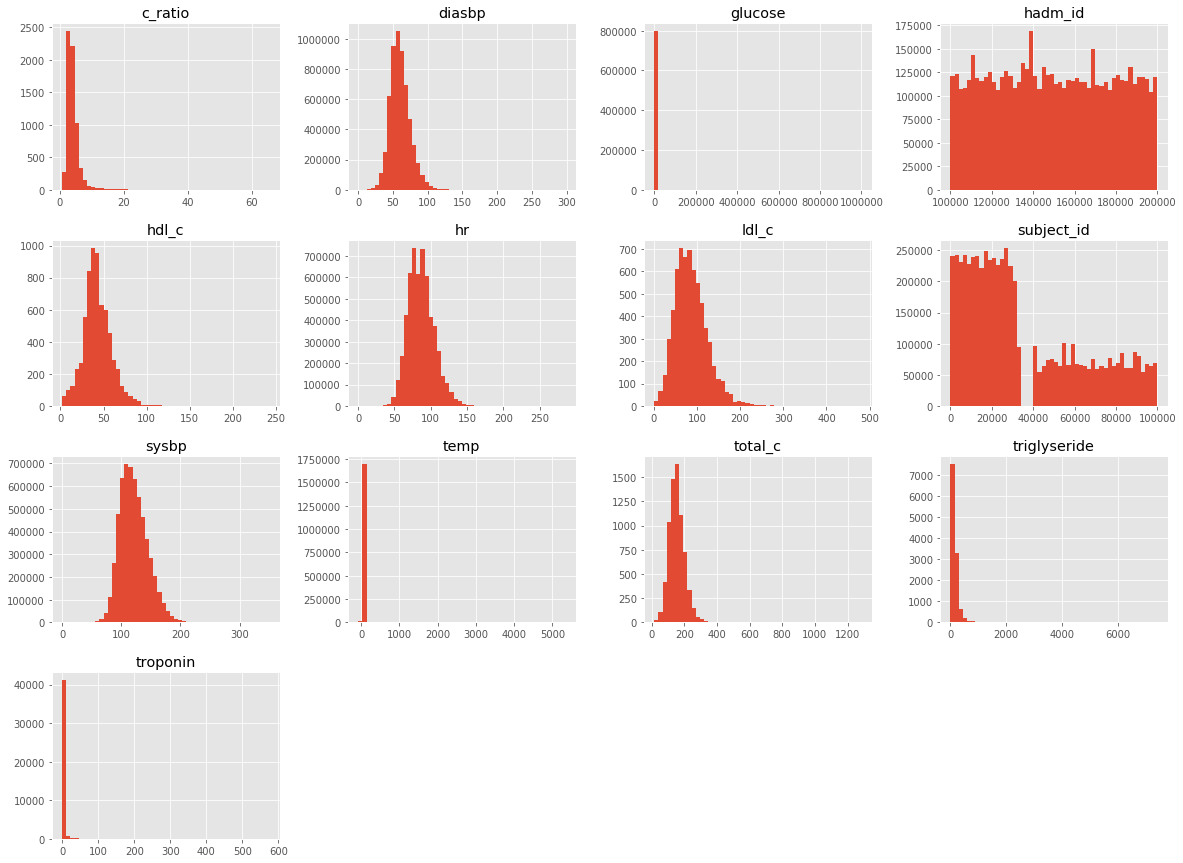

In [133]:
all_info.hist(bins=50, figsize=(20,15))
plt.show()

In [504]:
corr_matrix = all_info.corr()

In [505]:
corr_matrix['diasbp'].sort_values(ascending=False)

diasbp          1.000000
sysbp           0.557590
hr              0.202229
total_c         0.172705
ldl_c           0.160761
hdl_c           0.089439
subject_id      0.083311
glucose         0.014085
temp            0.006353
troponin        0.002559
hadm_id        -0.006182
c_ratio        -0.011799
triglyseride   -0.030156
Name: diasbp, dtype: float64

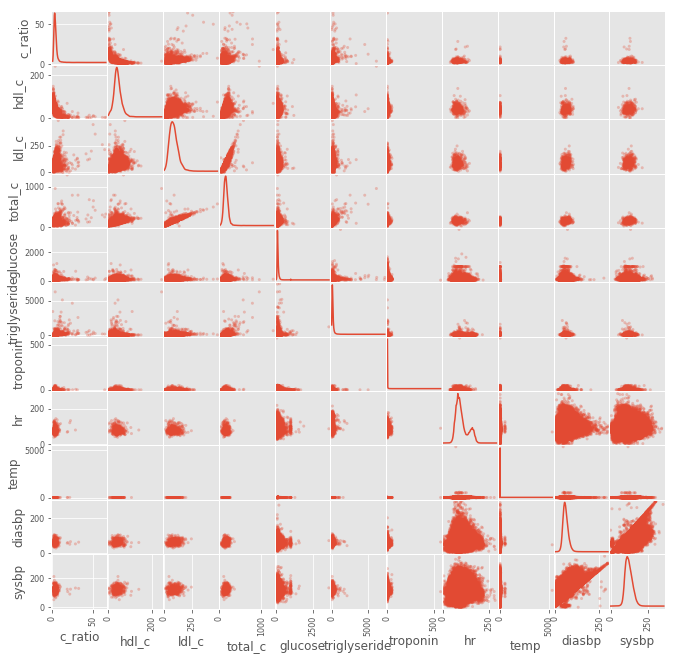

In [11]:
# scatter matrix
attributes = ['c_ratio','hdl_c','ldl_c','total_c','glucose','triglyseride','troponin','hr','temp','diasbp','sysbp']
fig = pd.plotting.scatter_matrix(all_info[attributes], alpha=0.3,figsize=(11,11), diagonal='kde')
plt.savefig('scatter_matrix.png')